In [20]:
# Cargamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from google.colab import files
from matplotlib.patches import Rectangle
from sklearn.metrics import ConfusionMatrixDisplay


In [21]:
# Subir y leer el CSV
from google.colab import files
up = files.upload()
csv_name = list(up.keys())[0]
df_users = pd.read_csv(csv_name)

# Crear carpetas de salida
import os
os.makedirs("clasificacion/figs", exist_ok=True)
os.makedirs("clasificacion/resultados", exist_ok=True)


Saving usuarios_win_mac_lin.csv to usuarios_win_mac_lin.csv


In [30]:
df_users = pd.read_csv("usuarios_win_mac_lin.csv")
df_users.head()


,duracion,paginas,acciones,valor,clase
0,7.0,2,4,8,2
1,21.0,2,6,6,2
2,57.0,2,4,4,2
3,101.0,3,6,12,2
4,109.0,2,6,12,2


In [33]:
X_df = df_users.drop(columns=["clase"])
y_sr = df_users["clase"]
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_sr, test_size=0.2, random_state=42, stratify=y_sr
)

In [34]:
# Separamos las variables
X = df_users.drop(columns=["clase"])
y = df_users["clase"]

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Clases únicas:", y.unique())


Shape X: (170, 4)
Shape y: (170,)
Clases únicas: [2 1 0]


In [24]:
# Entrenamiento del modelo
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (136, 4)  Test: (34, 4)


In [36]:
# Modelo de regresion logistica multiclase
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("logreg", LogisticRegression(multi_class="multinomial",
                                  solver="lbfgs", max_iter=500))
])
pipe.fit(X_train, y_train)

y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)
acc     = accuracy_score(y_test, y_pred)

# Reporte de clasificacion y matriz
print(f"Accuracy en test: {acc:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Accuracy en test: 0.7059

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        17
           1       1.00      0.38      0.55         8
           2       0.60      1.00      0.75         9

    accuracy                           0.71        34
   macro avg       0.78      0.69      0.67        34
weighted avg       0.77      0.71      0.69        34

Matriz de confusión:
[[12  0  5]
 [ 4  3  1]
 [ 0  0  9]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [42]:
# GUARDAR RESULTADOS (CSV/TXT)
# Métricas simples
with open("clasificacion/resultados/metricas.txt", "w") as f:
    f.write(f"Accuracy test: {acc:.4f}\n")

# Reporte de clasificación
rep = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(rep).to_csv("clasificacion/resultados/reporte_clasificacion_usuarios.csv")

# Matriz de confusión (CSV)
cm = confusion_matrix(y_test, y_pred, labels=clases)
pd.DataFrame(cm,
             index=[f"real_{c}" for c in clases],
             columns=[f"pred_{c}" for c in clases])\
  .to_csv("clasificacion/resultados/matriz_confusion_usuarios.csv", index=True)

# Coeficientes del modelo (interpretación)
log = pipe.named_steps["logreg"]
coef_tbl = pd.DataFrame(log.coef_, columns=X_df.columns, index=[f"clase_{c}" for c in clases])
coef_tbl.to_csv("clasificacion/resultados/coeficientes_logistica.csv")


Clases del modelo: [0 1 2]


<Figure size 640x480 with 0 Axes>

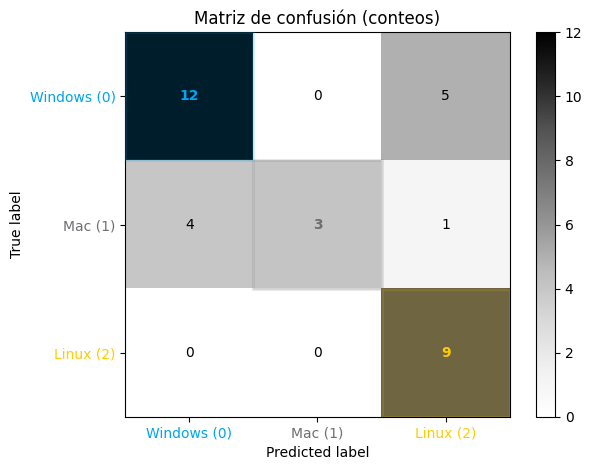

In [40]:
# Colores de marca
WIN = "#00A4EF"   # Windows azul
MAC = "#6E6E73"   # Apple "space gray"
LIN = "#FFCC00"   # Linux/Tux amarillo

labels = [0, 1, 2]
label_names = ["Windows (0)", "Mac (1)", "Linux (2)"]
brand_colors = [WIN, MAC, LIN]

clases = pipe.classes_
print("Clases del modelo:", clases)

# Matriz de confusión en CONTEOS (base neutra en grises)
plt.figure()
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    labels=labels,
    display_labels=label_names,
    cmap=plt.cm.Greys
)
ax = disp.ax_

for tick, c in zip(ax.get_xticklabels(), brand_colors):
    tick.set_color(c)
for tick, c in zip(ax.get_yticklabels(), brand_colors):
    tick.set_color(c)

n = len(labels)
for i, c in enumerate(brand_colors):
    rect = Rectangle((i - 0.5, i - 0.5), 1, 1,
                     facecolor=c, edgecolor=c, alpha=0.18, lw=2, zorder=3)
    ax.add_patch(rect)

for t in ax.texts:
    try:
        x, y = map(int, (round(float(t.get_position()[0])), round(float(t.get_position()[1]))))
        if x == y and 0 <= x < n:
            t.set_color(brand_colors[x])
            t.set_fontweight('bold')
    except Exception:
        pass

plt.title("Matriz de confusión (conteos)")
plt.grid(False)
plt.tight_layout()
plt.show()

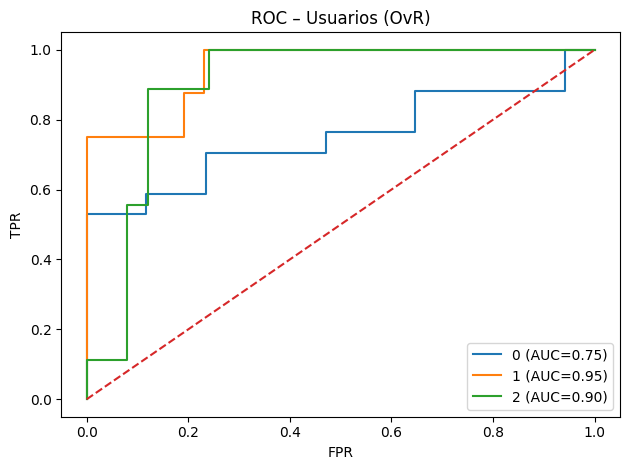

✔️ Guardado todo en:
 - clasificacion/figs  -> PNGs
 - clasificacion/resultados -> CSV/TXT


In [43]:
# Curvas ROC One-vs-Rest (PNG)
plt.figure()
for i, c in enumerate(clases):
    fpr, tpr, _ = roc_curve((y_test == c).astype(int), y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{label_names[i]} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – Usuarios (OvR)")
plt.legend()
plt.tight_layout()
plt.savefig("clasificacion/figs/roc_usuarios.png", dpi=150, bbox_inches="tight")
plt.show()

print("✔️ Guardado todo en:")
print(" - clasificacion/figs  -> PNGs")
print(" - clasificacion/resultados -> CSV/TXT")